<a href="https://colab.research.google.com/github/kylemath/EEG-Classification/blob/master/notebooks/CNN_LSTM_Muse_Kyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN_LSTM_MUSE_Kyle

Goal is to make a CNN LSTM stack that processes EEG trials as input and predicts binary category as output.


Strategy:
* Current code uses 25,000 examples of 100 long sentences in two categories, 
* Then is tested on 25000 sequences as well
* Instead try 250 by 100 data point long ERP for each trial 
* Predict attend left vs attend right on muse 375 data

Using: 
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/pbashivan/EEGLearn
* https://github.com/tevisgehr/EEG-Classification
* https://github.com/kylemath/eeg-notebooks

Resources:
*   http://proceedings.mlr.press/v56/Thodoroff16.pdf
*   https://arxiv.org/abs/1511.06448




In [1]:
!git clone https://github.com/tevisgehr/EEG-Classification.git
%cd EEG-Classification
from eeg_learn_functions import *
%cd ..

!git clone https://github.com/kylemath/eeg-notebooks.git
%cd eeg-notebooks/notebooks
!pip install mne
from utils import utils


Cloning into 'EEG-Classification'...
remote: Enumerating objects: 201, done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 201
Receiving objects: 100% (201/201), 16.68 MiB | 20.35 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/EEG-Classification
/content
Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 1632 (delta 62), reused 145 (delta 43), pack-reused 1466
Receiving objects: 100% (1632/1632), 107.78 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (685/685), done.
Checking out files: 100% (485/485), done.
/content/eeg-notebooks/notebooks
    100% |████████████████████████████████| 6.2MB 5.6MB/s 
  Running setup.py bdist_wheel for mne ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

In [3]:
sub = 105
raw = utils.load_data('visual/cueing', sfreq=256.,subject_nb=sub, session_nb=1)
raw.append(utils.load_data('visual/cueing', sfreq=256.,subject_nb=sub, session_nb=2))

Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.


**Filtering**

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.



Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 8.000 (s)


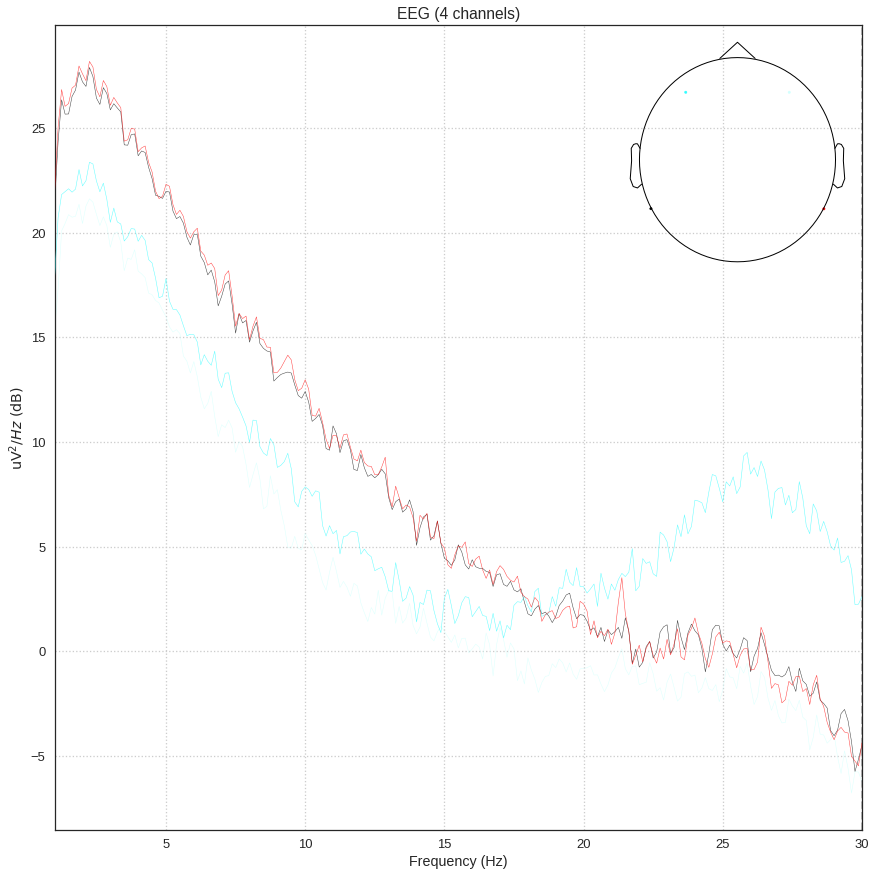

In [4]:
raw.filter(1,30, method='iir' )
raw.plot_psd(fmin=1, fmax=30 );

**Epoching**

Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.



111 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  49.54954954954955


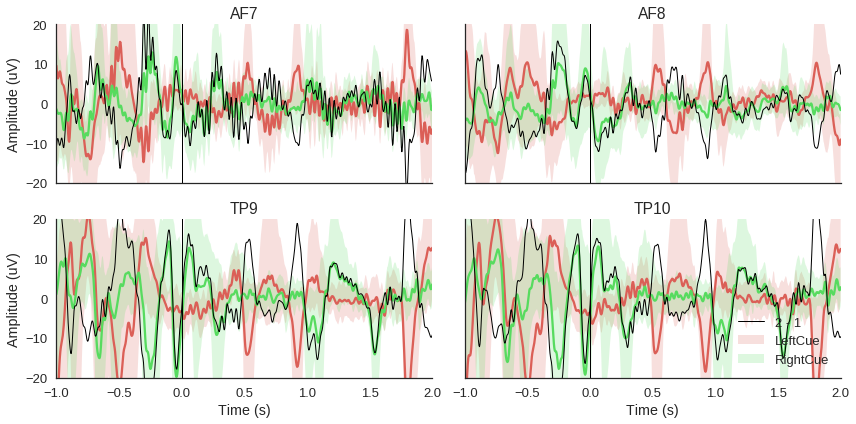

In [7]:
from mne import Epochs, find_events, concatenate_raws
from collections import OrderedDict

events = find_events(raw)
event_id = {'LeftCue': 1, 'RightCue': 2}

rej_thresh_uV = 1000
rej_thresh = rej_thresh_uV*1e-6

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-1, tmax=2, baseline=(-1, 0), 
                preload=True,reject={'eeg':rej_thresh},
                verbose=False, picks=[0, 1, 2, 3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

%matplotlib inline
conditions = OrderedDict()
conditions['LeftCue'] = [1]
conditions['RightCue'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, ylim=(-20,20) )

**Spectrogram**

Only Tp9 and Tp10 are considered on each trial, and their difference is used to create a single image for each trial. 

two changes are made here to create a small square output for each trial.. Many frequencies are used in the wavelet analysis (49) while the output of the morlet is decimated in time by a factor of 16. This creates 49x49 spectograms




Applying baseline correction (mode: mean)
(26, 4, 49, 49)
(26, 49, 49, 4)
Time Points: 49
Frequencies: 49
Trials: 26


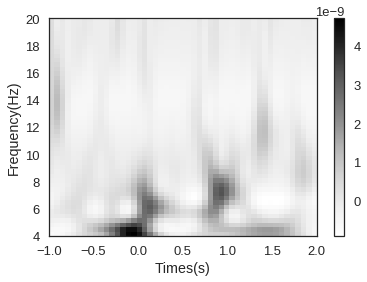

In [19]:
from mne.time_frequency import tfr_morlet
import numpy as np

frequencies =  np.linspace(4, 20, 49, endpoint=True)

wave_cycles = 6

 # Compute morlet wavelet

# Left Cue
tfr = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=False,picks=[0,1,2,3],average=False,decim=16)
tfr = tfr.apply_baseline([-1,-.5],mode='mean')

print(tfr.data.shape)
left_power_out = np.moveaxis(tfr.data,1,3)
print(left_power_out.shape)

print('Time Points: ' + str(len(tfr.times)))
print('Frequencies: ' + str(len(tfr.freqs)))
print('Trials: ' + str(len(tfr._data)))

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(left_power_out[1,:,:,0],extent=[tfr.times[0], tfr.times[-1], tfr.freqs[-1], tfr.freqs[0]], aspect='auto')
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('Times(s)')
plt.ylabel('Frequency(Hz)')
plt.colorbar()


**Spectrogram - Other Condition**

Now the other condition, right cue, is done, and the two sets of images and labels are concatenated into X and Y variables

X is a trials x 49 x 49 matrix
Y is a trials array of attention direction labels


Applying baseline correction (mode: mean)
(30, 4, 49, 49)
(30, 49, 49, 4)
Right Time Points: 49
Right Frequencies: 49
Right Trials: 30
Combined X Shape: (56, 49, 49, 4)
Combined Y Shape: (56,)
Combined Y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
X Example:


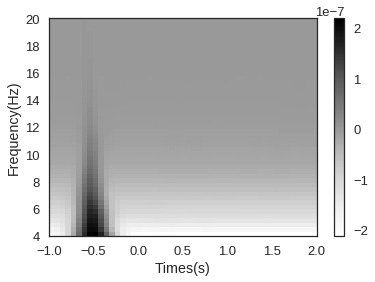

In [20]:
# Right Cue
tfr = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                      n_cycles=wave_cycles, return_itc=False,picks=[0,1,2,3],average=False,decim=16)
tfr = tfr.apply_baseline([-1,-.5],mode='mean')

print(tfr.data.shape)
right_power_out = np.moveaxis(tfr.data,1,3)
print(right_power_out.shape)


print('Right Time Points: ' + str(len(tfr.times)))
print('Right Frequencies: ' + str(len(tfr.freqs)))
print('Right Trials: ' + str(len(tfr._data)))

%matplotlib inline
plt.imshow(right_power_out[6,:,:,0],extent=[tfr.times[0], tfr.times[-1], tfr.freqs[-1], tfr.freqs[0]], aspect='auto')
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('Times(s)')
plt.ylabel('Frequency(Hz)')
plt.colorbar()

X = np.append(left_power_out,right_power_out,0);
print('Combined X Shape: ' + str(X.shape))
Y = np.append(np.zeros(len(left_power_out)), np.ones(len(right_power_out)),0);
print('Combined Y Shape: ' + str(Y.shape))
print('Combined Y: ' + str(Y))
print('X Example:')

''

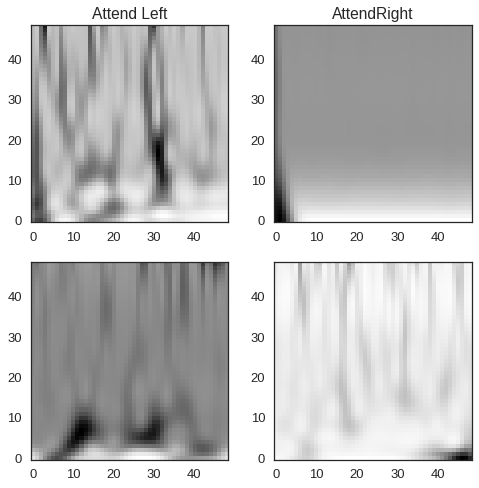

In [24]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title('Attend Left')
axarr[0][0].imshow(X[0,:,:,1])
axarr[0][0].invert_yaxis()
axarr[1][0].imshow(X[1,:,:,1])
axarr[1][0].invert_yaxis()

axarr[0][1].set_title('AttendRight')
axarr[0][1].imshow(X[-1,:,:,1])
axarr[0][1].invert_yaxis()
axarr[1][1].imshow(X[-2,:,:,1])
axarr[1][1].invert_yaxis()


;

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,shuffle=True)
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

print(y_train)

(44,)
(44, 49, 49, 4)
(12,)
(12, 49, 49, 4)
[1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.]


In [35]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 44
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 49, 49

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train)
print(y_train.shape)
input_shape = (img_rows, img_cols,4)

x_train shape: (44, 49, 49, 4)
44 train samples
12 test samples
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(44, 2)


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [37]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          verbose=True)
                   

Train on 44 samples, validate on 12 samples
Epoch 1/100
44/44 [==============================] - 0s 8ms/step - loss: 0.6931 - acc: 0.4545 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
44/44 [==============================] - 0s 464us/step - loss: 0.6931 - acc: 0.5455 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/100
44/44 [==============================] - 0s 479us/step - loss: 0.6928 - acc: 0.5455 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/100
44/44 [==============================] - 0s 470us/step - loss: 0.6925 - acc: 0.5455 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/100
44/44 [==============================] - 0s 454us/step - loss: 0.6920 - acc: 0.5455 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 6/100
44/44 [==============================] - 0s 438us/step - loss: 0.6916 - acc: 0.5455 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 7/100
44/44 [==============================] - 0s 454us/step - loss: 0.6911 - acc: 0.5455 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 8/100
44/44 [========

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


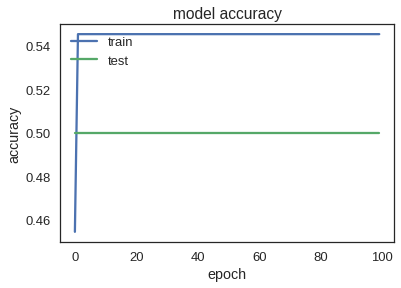

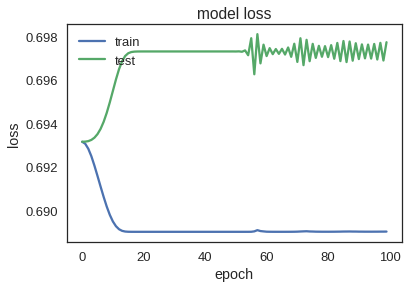

In [38]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [0]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [0]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [0]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [0]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [0]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [0]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [0]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [20]:
%cd EEG-Classification/


/content/EEG-Classification


In [28]:

file_names = ['data/ML101_KS.csv',
              'data/ML101_US.csv',
              'data/ML102_KS.csv',
              'data/ML102_US.csv',
              'data/ML103_KS.csv',
              'data/ML103_US.csv',
              'data/ML104_KS.csv',
              'data/ML104_US.csv',
              'data/ML105_KS.csv',
              'data/ML105_US.csv',
              'data/ML106_KS.csv',
              'data/ML106_US.csv',
              'data/ML107_KS.csv',
              'data/ML107_US.csv',
              'data/ML108_KS.csv',
              'data/ML108_US.csv']

file_names = ['data/ML101_KS.csv',
              'data/ML101_US.csv']

labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/ML101_KS.csv . ( 1  of  2 )
234  frames generated with label  1 .


Processing session:  data/ML101_US.csv . ( 2  of  2 )
224  frames generated with label  0 .


